In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
words = open("./names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n8 = int(0.8 * len(words))
n9 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n8])
Xde, Yde = build_dataset(words[n8:n9])
Xte, Yte = build_dataset(words[n9:])

print(Xtr.shape, Ytr.shape)
print(Xde.shape, Yde.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_emb = 10 # number of embedding dim
n_hidden = 200 # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1 # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 #(batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.1 if k < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")
        
    lossi.append(loss.log10().item())

      0/ 200000 22.6744
  10000/ 200000 2.5877
  20000/ 200000 2.4022
  30000/ 200000 2.4360
  40000/ 200000 2.4083
  50000/ 200000 2.8067
  60000/ 200000 2.0619
  70000/ 200000 2.4854
  80000/ 200000 2.7718
  90000/ 200000 2.3828
 100000/ 200000 2.1090
 110000/ 200000 2.2108
 120000/ 200000 1.9361
 130000/ 200000 1.9425
 140000/ 200000 2.5051
 150000/ 200000 2.5024
 160000/ 200000 2.1794
 170000/ 200000 2.2998
 180000/ 200000 2.3643
 190000/ 200000 2.3001


**Notice loss at 0 is high 22.6 and rapidly comes down** - Weights Init is messed up

You would typically want loss to be equally distributed initially with a little bit of entropy for exploration

$$ - \log(1/27.0) $$

In [11]:
- torch.tensor(1 / 27.0).log()

tensor(3.2958)

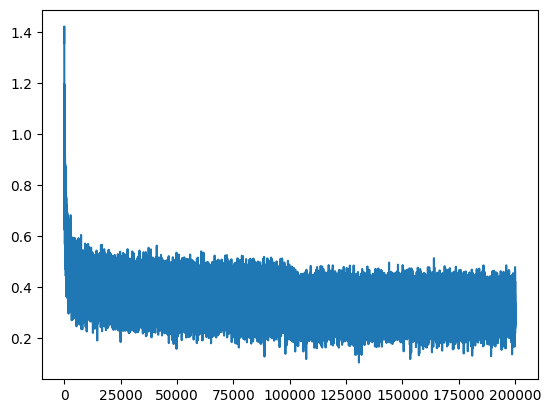

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # disables grad tracking
def split_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xde, Yde),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    h = torch.tanh( emb.view(-1, 30) @ W1 + b1 )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item()) 

split_loss('train')
split_loss('dev')

train 2.1279425621032715
dev 2.1635923385620117


In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, 10)
        h = torch.tanh( emb.view(-1, n_emb * block_size) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

carmah
ambrilli
kemri
reh
cassanden
jazhuel
deviah
jareen
nellara
chaiiv
kaleigh
ham
prin
quinn
sroj
raivan
quinathondiaryni
jaxeenissa
med
edi
